In [3]:
# Step 1: Importing the necessary libraries

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE 
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers,Sequential
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"] 

In [ ]:
# Step 2: Download the dataset

# https://www.kaggle.com/mlg-ulb/creditcardfraud?select=creditcard.csv
# The dataset I have used contains data about credit card transactions with 492 frauds out of 284,807 transactions.
# All variables in the dataset are numerical.
# The data has been transformed using principal component analysis (PCA).

In [38]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Step 3: Evaluating the shape of data

df.shape

(284807, 31)

In [6]:
# Step 4: Checking for Null values

df.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

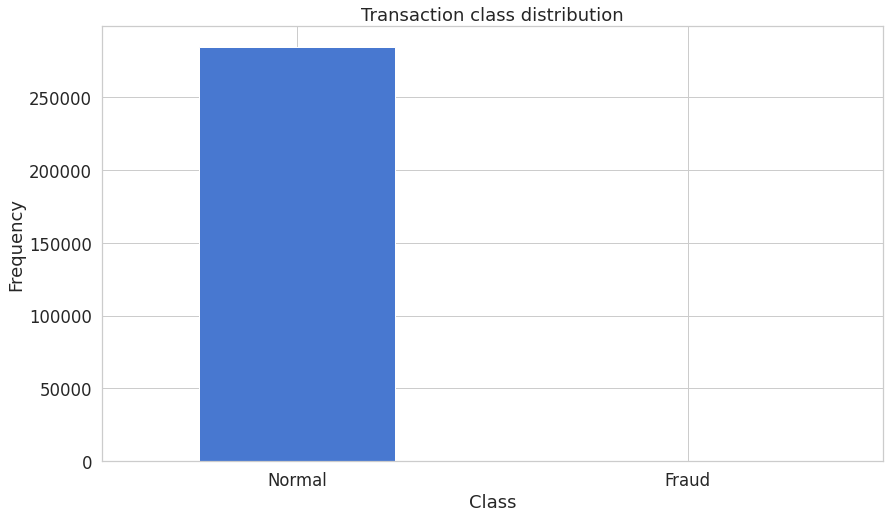

In [9]:
# Step 5: Checking number of records of each kind of transaction class (Fraud and Non-Fraud)

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [13]:
# Step 6: The dataset is highly imbalanced. Individually evaluating fraud(1) and non-fraud(0) transactions.

frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [12]:
frauds.shape

(492, 31)

In [11]:
normal.shape

(284315, 31)

In [ ]:
# The 3 features taken into acount are 
# 1. Time
# 2. Amount
# 3. Class

In [14]:
# Step 7: Checking the amount of money involved in each kind of transaction
# frauds transactions
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [15]:
# Non-fraud transactions
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

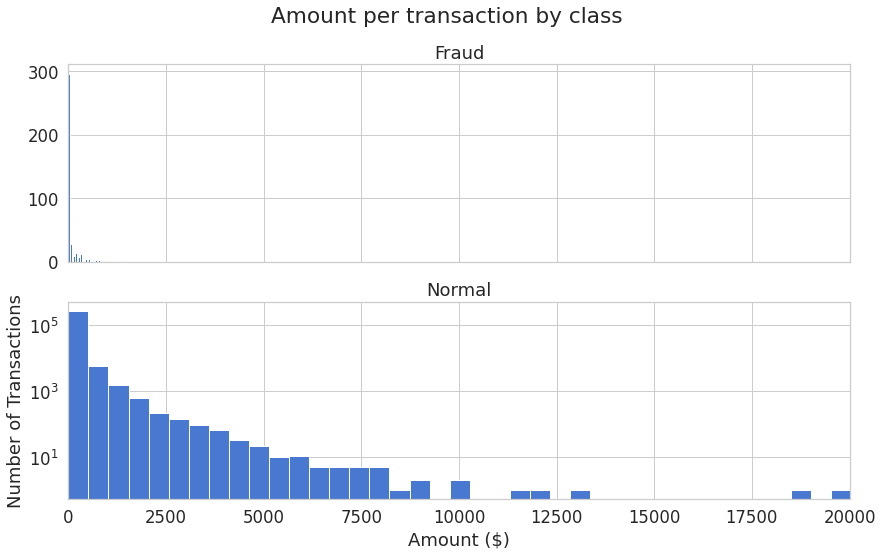

In [17]:
# Step 8: Graphical representation of Amount

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()


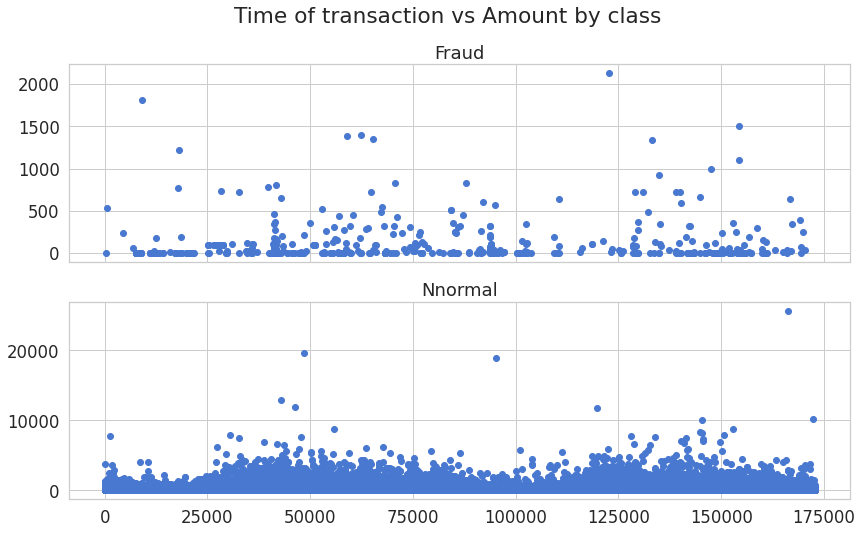

In [18]:
# Step 9: Plotting time of transaction to check for correlations

f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Nnormal')
plt.show()

In [19]:
# I am eliminating the Time feature, as it is not essential.
data = df.drop(['Time'], axis=1)

In [21]:
# The numerical amount in fraud and normal cases have a major difference. Hence, i am going to scale.
# Step 10: Scaling the Amount using StandardScaler

from sklearn.preprocessing import StandardScaler
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [ ]:
# I have used Autoencoders for the fraud detection model.
# The reason why i am using this method is to let the model learn the best representation of non-fraudulent cases so that it automatically distinguishes the other case from it.

In [22]:
# Step 11: Building the model

non_fraud = data[data['Class'] == 0] #.sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

In [23]:
# Step 12: Splitting the data into 80% training and 20% testing

X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train_fraud = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values  
X_train.shape

(227451, 29)

In [30]:
#                         AUTOENCODER MODEL
input_layer = Input(shape=(X.shape[1],))

# encoding 
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

# decoding
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

# output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [31]:
# Step 13: Training the credit card fraud detection model

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [32]:
# Step 14: Scaling the values
x = data.drop(["Class"], axis=1)
y = data["Class"].values
x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

autoencoder.fit(x_norm[0:2000], x_norm[0:2000], batch_size = 256, epochs = 10, shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 1s 36ms/step - loss: 0.2060 - val_loss: 0.2050
Epoch 2/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2056 - val_loss: 0.2046
Epoch 3/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2052 - val_loss: 0.2042
Epoch 4/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2048 - val_loss: 0.2038
Epoch 5/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2043 - val_loss: 0.2034
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2039 - val_loss: 0.2030
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2035 - val_loss: 0.2025
Epoch 8/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2031 - val_loss: 0.2021
Epoch 9/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2026 - val_loss: 0.2017
Epoch 10/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2022 - val_loss: 0.2012


In [33]:
# Obtain the hidden representation
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [34]:
# Step 15: Model Prediction
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [35]:
# Getting the representation data
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [36]:
# Train, Test, Split
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

In [37]:
# CREDIT CARD FRAUD DETECTION PREDICTION MODEL

clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification  Report: ")
print ( classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification  Report: 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       755
         1.0       0.99      0.71      0.83       118

    accuracy                           0.96       873
   macro avg       0.97      0.86      0.90       873
weighted avg       0.96      0.96      0.96       873


Accuracy Score:  0.9599083619702177


In [ ]:
# I have demonstrated precision of 96% & accuracy of 95%